In [7]:
import numpy as np
import pandas as pd
import joblib
import rasterio
from rasterio.crs import CRS
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

model_path = "../../../models/agb/xgbmodel.joblib.pkl"
xgb = joblib.load(model_path)
image = rasterio.open(fr'C:\Users\admin\OneDrive\Computing\Yr5 Advanced Computing\MAC Project\Carbon-Trading-Verification\scotland_carbon\data\LANDSAT_INVEN_EVAL.tif')

num_bands = image.count
img_width = image.width
img_height = image.height
num_pixels = img_height * img_width
all_data = []
print("Image shape:", image.shape)
# data = image.read(1)
# plot_graph(data,"")

# data = 35000 - data
# plot_graph(data,"")





Image shape: (131, 193)


In [8]:
print("Converting Raster to Array...")
for i in tqdm(range(num_bands)):
    data = image.read(i+1)
    data = pd.DataFrame(data).fillna(0).to_numpy()
    all_data.append(data)

all_data = np.dstack(all_data)
all_data_shape = all_data.shape
print("Raster array shape:", all_data_shape)

# all_data = 35000 - all_data


100%|████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 857.31it/s]

Converting Raster to Array...
Raster array shape: (131, 193, 12)


In [9]:
print("Calculating AGB...")
result_data = []
non_zero = 0
for t in tqdm(all_data):
    z = xgb.predict(t)
    result_data.append(z)
    non_zero += np.count_nonzero(z)
    z[z!=z] = 0
    # print(torch.min(z), torch.max(z))
print("non_zero:", non_zero)

# result_data = np.exp(np.stack(result_data))
result_data = np.stack(result_data)

# Transform result_data for display
# result_data = np.exp(result_data)
print(result_data)


  8%|████▌                                                  | 11/131 [00:00<00:01, 106.80it/s]

Calculating AGB...


100%|██████████████████████████████████████████████████████| 131/131 [00:00<00:00, 178.47it/s]

non_zero: 25283
[[542.74634  491.022    192.04065  ... 127.64986  174.67494  145.8145  ]
 [317.47284  347.28522  103.01184  ... 123.59303  125.63426  121.012276]
 [278.8767   138.11073  131.72568  ... 150.19287  125.82298  191.5623  ]
 ...
 [ 77.7767    75.49413  100.2558   ... 117.81953  104.286804  94.625206]
 [129.98767  146.867    129.88828  ... 110.12034   91.851295 120.37256 ]
 [125.58935  128.85074  116.18091  ... 201.68901  145.2045   134.02742 ]]


In [16]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

def plot_graph(result_data, file_name):
    fontprops = fm.FontProperties(size=12)
    # https://epsg.io/transform#s_srs=27700&t_srs=4326&x=293167.0000000&y=652518.0000000
    # topleft - x = -3°42.2263', y = 55°45.25162'
    # x = -3.7037717°, y = 55.7541937°
    # bottomright - x = -2.7696528°, y = 55.4075244°
    x_coord_l, x_coord_r = -3.7037717, -2.7696528
    y_coord_t, y_coord_b = 55.7541937, 55.4075244
    x_shape = result_data.shape[1]
    y_shape = result_data.shape[0]

    def x_format_func(value, tick_number):
        out = (x_coord_l + (value / x_shape * (x_coord_r - x_coord_l)))
        return "{v:.2f}\N{DEGREE SIGN}".format(v=out)

    def y_format_func(value, tick_number):
        out = (y_coord_t - (value / y_shape * (y_coord_t - y_coord_b)))
        return "{v:.2f}\N{DEGREE SIGN}".format(v=out)

    ax = plt.axes()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(x_format_func))
    # ax.xaxis.set_major_locator(plt.MaxNLocator(7))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(y_format_func))
    # ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    scalebar = AnchoredSizeBar(ax.transData,
                               33.3, '10 km', 'lower right', 
                               pad=0.1,
                               color='black',
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)

    ax.add_artist(scalebar)


    plt.xlabel("Latitude")
    plt.ylabel("Londgitude")
    plt.imshow(result_data, cmap='YlGn')
    plt.colorbar(label="Amount of Above Ground Biomass (Mg C/ha)")
    plt.savefig(file_name)
    plt.show()

(130, 192)


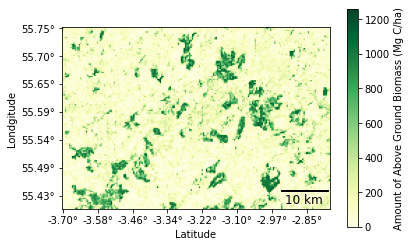

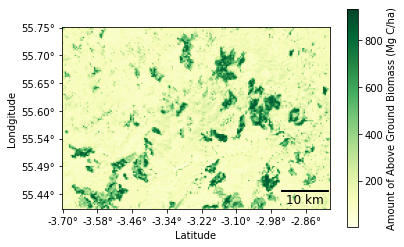

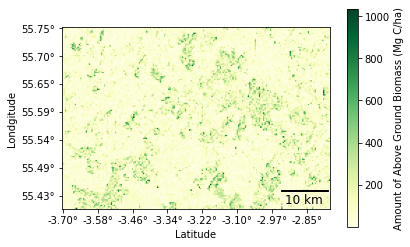

In [17]:
image = rasterio.open(fr'C:\Users\admin\OneDrive\Computing\Yr5 Advanced Computing\MAC Project\Carbon-Trading-Verification\scotland_carbon\data\agb_c1_27700_300m_clipped.tif')
data = image.read(1)
print(data.shape)
plot_graph(data, '../../../report_output/experiment1/agb/xgb_truth.png')
# plot_graph(np.clip(data, 0, 800), '../../../report_output/experiment1/agb/xgb_truth.png')
plot_graph(result_data, '../../../report_output/experiment1/agb/xgb_pred.png')
plot_graph(np.abs(data-result_data[:130,:192]), '../../../report_output/experiment1/agb/xgb_err.png')